 Exoplanet Archive sorgulanıyor...
 Hedef sayısı: 1

 Bitti | OK: 0 | Skip: 0 | No-data: 0 | Error: 1
 Çıktı klasörü: D:\exoplanet_output
- PNG: D:\exoplanet_output\png
- CSV: D:\exoplanet_output\csv
- Manifest: D:\exoplanet_output\manifest.jsonl
- Log: D:\exoplanet_output\run_log.jsonl


<Figure size 900x400 with 0 Axes>

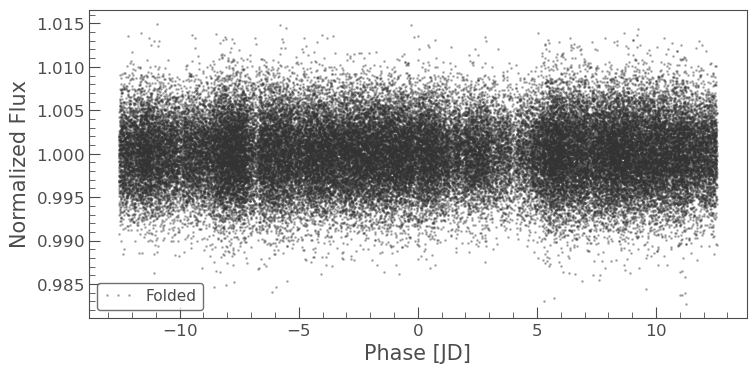

<Figure size 900x400 with 0 Axes>

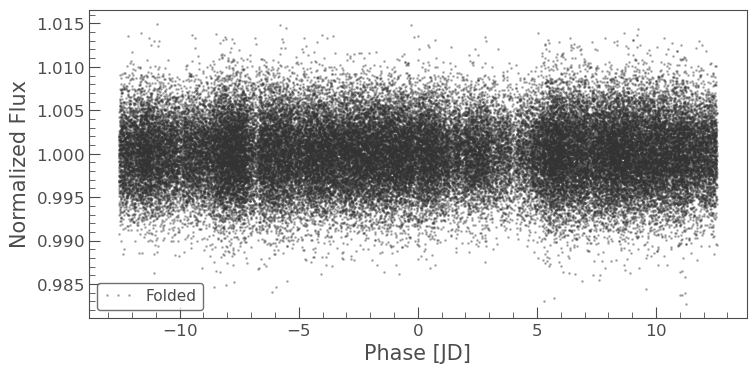

<Figure size 900x400 with 0 Axes>

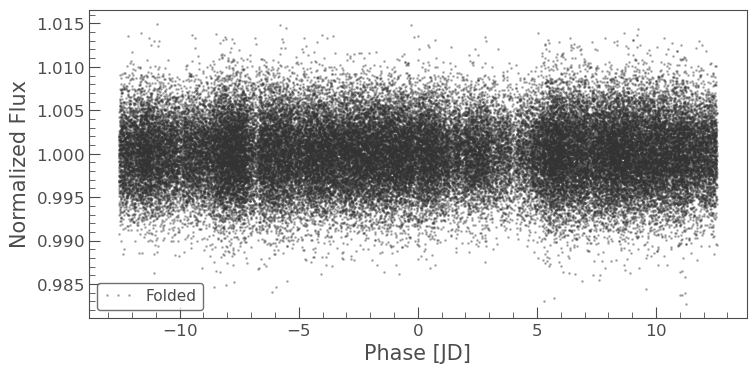

In [6]:
import os
import re
import json
import math
import time
import warnings
from concurrent.futures import ThreadPoolExecutor, as_completed

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy import units as u
from astroquery.nasa_exoplanet_archive import NasaExoplanetArchive
import lightkurve as lk

### ayarlar
OUTPUT_DIR = r"D:\exoplanet_output"
CACHE_DIR = os.path.join(OUTPUT_DIR, "lk_cache")
PNG_DIR = os.path.join(OUTPUT_DIR, "png")
CSV_DIR = os.path.join(OUTPUT_DIR, "csv")
MANIFEST = os.path.join(OUTPUT_DIR, "manifest.jsonl")
LOGFILE = os.path.join(OUTPUT_DIR, "run_log.jsonl")

MAX_WORKERS = max(4, os.cpu_count() or 4)   # paralel iş sayısı
MAX_TARGETS = 1                          # None yazılırsa bütün veriler!!!
MISSION_PRIORITY = ["TESS", "Kepler", "K2"]  # Lightkurve mission önceliği
AUTHOR_PRIORITY = ["SPOC", "QLP", "Kepler", "K2"]
FLATTEN_WINDOW = 301                         # flatten penceresi
TIME_BIN = 0.001                             # gün
RETRY = 3                                    # her hedef için yeniden deneme sayısı
RETRY_BASE_SLEEP = 2.0                       # üssel bekleme tabanı (s)
###

# uyarıları kapatmak için
warnings.filterwarnings("ignore")
try:
    lk.log.setLevel("ERROR")
except Exception:
    pass

###

for d in [OUTPUT_DIR, CACHE_DIR, PNG_DIR, CSV_DIR]:
    os.makedirs(d, exist_ok=True)

def sanitize(name: str) -> str:
    name = re.sub(r"[^\w\-\.]+", "_", name, flags=re.UNICODE)
    return re.sub(r"_+", "_", name).strip("_")

def save_line(path, rec: dict):
    with open(path, "a", encoding="utf-8") as f:
        f.write(json.dumps(rec, ensure_ascii=False) + "\n")

def safe_value(x, unit=None):
    """Astropy Quantity / numpy / float için güvenli değer alımı."""
    if x is None:
        return None
    
    try:
        if pd.isna(x):
            return None
    except Exception:
        pass
    
    if hasattr(x, "to") and hasattr(x, "unit"):
        try:
            return x.to(unit).value if unit else x.value
        except Exception:
            # bazen unit already in correct dims or missing, son çare olarak:
            try:
                return x.value
            except Exception:
                return float(x)
    
    try:
        return float(x)
    except Exception:
        return None

def get_time_offset(lc) -> float:
    """Lightkurve zaman formatına göre BTJD/BKJD ofseti."""
    fmt = getattr(lc, "time_format", None)
    if fmt is None:
        fmt = getattr(getattr(lc, "time", None), "format", None)
    if fmt:
        f = fmt.lower()
        if f == "btjd":
            return 2457000.0
        if f == "bkjd":
            return 2454833.0
    return 0.0  #JD/BJD ise 0 bırak fold epoch_time mutlak değil ofsetli olmalı

def search_download_lightcurve(hostname: str):
    """Önce mission, sonra author önceliği ile indir + stitch + temizle + flatten."""
    
    for mission in MISSION_PRIORITY:
        search = lk.search_lightcurve(hostname, mission=mission)
        if len(search) == 0:
            continue
        
        for author in AUTHOR_PRIORITY:
            sub = search[search.author == author]
            if len(sub) == 0:
                continue
            try:
                lcc = sub.download_all(download_dir=CACHE_DIR)
                if lcc is None or len(lcc) == 0:
                    continue
                lc = lcc.stitch().remove_nans()
                try:
                    lc = lc.flatten(window_length=FLATTEN_WINDOW)
                except Exception:
                    lc = lc.normalize()
                return lc, mission, author
            except Exception:
                continue
        
        try:
            lcc = search.download_all(download_dir=CACHE_DIR)
            if lcc and len(lcc) > 0:
                lc = lcc.stitch().remove_nans()
                try:
                    lc = lc.flatten(window_length=FLATTEN_WINDOW)
                except Exception:
                    lc = lc.normalize()
                return lc, mission, "auto"
        except Exception:
            pass
    return None, None, None

def fold_plot_save(planet, host, P_day, t0_bjd, dur_hr, lc, mission, author):
    """Faz katla, PNG+CSV kaydet, manifest yaz."""
    base = sanitize(planet)
    png_path = os.path.join(PNG_DIR, f"{base}.png")
    csv_path = os.path.join(CSV_DIR, f"{base}.csv")

    # epoch_time: lc.time_format ofsetine göre t0'u çevir
    offset = get_time_offset(lc)
    epoch_time = t0_bjd - offset

    folded = lc.fold(period=P_day, epoch_time=epoch_time)
    folded_binned = folded.bin(time_bin_size=TIME_BIN)

    # x-limit: birkaç transit süresi kadar pencere
    if dur_hr is not None and not (isinstance(dur_hr, float) and math.isnan(dur_hr)):
        dur_days = dur_hr / 24.0
        half_win = min(0.5, 3.0 * (dur_days / P_day))
    else:
        half_win = 0.15

    # PNG
    plt.figure(figsize=(9, 4))
    folded.plot(marker=".", linestyle="none", alpha=0.3, label="Folded")
    folded_binned.plot(marker=".", linestyle="none", label="Binned")
    plt.xlim(-half_win, half_win)
    ttl = f"{planet} — Transit (mission={mission}, author={author})"
    plt.title(ttl)
    plt.xlabel("Faz (gün)")
    plt.ylabel("Normalize Akı")
    plt.legend()
    plt.tight_layout()
    plt.savefig(png_path, dpi=150)
    plt.close()

    # CSV
    df = pd.DataFrame({
        "phase_day": folded.time.value,
        "flux": folded.flux.value,
        "flux_err": getattr(folded, "flux_err", None)
            if hasattr(folded, "flux_err") else None
    })
    df.to_csv(csv_path, index=False)

    # manifest
    save_line(MANIFEST, {
        "planet": planet,
        "host": host,
        "period_day": P_day,
        "t0_bjd": t0_bjd,
        "time_offset_applied": offset,
        "mission": mission,
        "author": author,
        "png": os.path.basename(png_path),
        "csv": os.path.basename(csv_path)
    })

def already_done(planet: str) -> bool:
    base = sanitize(planet)
    return (os.path.exists(os.path.join(PNG_DIR, f"{base}.png")) and
            os.path.exists(os.path.join(CSV_DIR, f"{base}.csv")))

def process_one(row_dict):
    """Bir hedefi tüm aşamalarıyla işle (retry dahil)."""
    planet = str(row_dict["pl_name"])
    host = str(row_dict["hostname"]) if row_dict.get("hostname") is not None else planet

    if already_done(planet):
        save_line(LOGFILE, {"planet": planet, "status": "skip_exists"})
        return planet, "skip_exists"

    # birimler
    P_day = safe_value(row_dict.get("pl_orbper"), u.day)
    t0_bjd = safe_value(row_dict.get("pl_tranmid"), u.day)  # BJD_TDB gün
    dur_hr = safe_value(row_dict.get("pl_trandur"), u.hour)

    if P_day is None or t0_bjd is None:
        save_line(LOGFILE, {"planet": planet, "status": "skip_missing_params"})
        return planet, "skip_missing_params"

  
    last_err = None
    for attempt in range(RETRY):
        try:
            lc, mission, author = search_download_lightcurve(host)
            if lc is None:
                save_line(LOGFILE, {"planet": planet, "status": "no_data"})
                return planet, "no_data"

            fold_plot_save(planet, host, P_day, t0_bjd, dur_hr, lc, mission, author)
            save_line(LOGFILE, {"planet": planet, "status": "ok", "mission": mission, "author": author})
            return planet, "ok"
        except Exception as e:
            last_err = repr(e)
            time.sleep(RETRY_BASE_SLEEP * (2 ** attempt))

    save_line(LOGFILE, {"planet": planet, "status": "error", "error": last_err})
    return planet, "error"

def fetch_table():
    # Transit parametreleri dolu hedefler
    
    tbl = NasaExoplanetArchive.query_criteria(
        table="pscomppars",
        select="pl_name,hostname,pl_orbper,pl_tranmid,pl_trandur",
        where="pl_tranmid IS NOT NULL AND pl_orbper IS NOT NULL"
    )
    if MAX_TARGETS:
        tbl = tbl[:MAX_TARGETS]
    # astropy.Table -> dict list (units korunur)
    rows = []
    for r in tbl:
        rows.append({k: r[k] for k in tbl.colnames})
    return rows

def main():
    print(" Exoplanet Archive sorgulanıyor...")
    rows = fetch_table()
    total = len(rows)
    print(f" Hedef sayısı: {total}")

    ok = skip = nodata = err = 0
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as ex:
        futures = [ex.submit(process_one, r) for r in rows]
        for f in as_completed(futures):
            planet, status = f.result()
            if status == "ok":
                ok += 1
            elif status.startswith("skip"):
                skip += 1
            elif status == "no_data":
                nodata += 1
            else:
                err += 1

    print(f"\n Bitti | OK: {ok} | Skip: {skip} | No-data: {nodata} | Error: {err}")
    print(f" Çıktı klasörü: {OUTPUT_DIR}\n- PNG: {PNG_DIR}\n- CSV: {CSV_DIR}\n- Manifest: {MANIFEST}\n- Log: {LOGFILE}")

if __name__ == "__main__":
    main()